In [1]:
from lmfit import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numdifftools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
'''note, this function, the objective function, could be a numerical solution to some problem, with parameters, 
and that returns an array of parameters that can be compared to a calibration dataset.  This would allow the 
use of the more sophisticated fitting methods in lmfit.  Could also call an external model (e.g. PHREEQC,
HYDRUS) with the function below'''

#define the objective function (i.e., the model, van Genuchten 1980 theta and k)

def swcc(h,Ks,alpha,n,Qr,Qs,l):
    theta = ((Qr + (Qs - Qr))/(1+(alpha*np.abs(h))**n)**(1-(1/n)))
    m = (1-(1/n))
    Se = theta/Qs
    K = Ks*(Se**l)*(1-(1-(Se**(l/m)))**m)**2
    #must pass the data as a 1d structure
    return np.concatenate((theta, K))

In [3]:
#create a model from a function
swcc_model = Model(swcc)
params = swcc_model.make_params()

#set initial values and bounds
l = params['l']
l.min = -6.0
l.max = 10.0
l.value = 0.5
l.init_value = 0.5
l.vary = False

Ks = params['Ks']
Ks.min = 0.1
Ks.max = 20.0
Ks.value = 1.0
Ks.init_value = 1.0

alpha = params['alpha']
alpha.min = 0.001
alpha.max = 0.1
alpha.value = 0.0186
alpha.init_value = 0.0186

n = params['n']
n.min = 0.1
n.max = 10.0
n.value = 1.323
n.init_value = 1.323

Qr = params['Qr']
Qr.min = 0.0
Qr.max = 0.15
Qr.value = 0.008
Qr.init_value = 0.008
Qr.vary = False

Qs = params['Qs']
Qs.min = 0.21
Qs.max = 0.65
Qs.value = 0.295
Qs.init_value = 0.295
Qs.vary = True

params

name,value,initial value,min,max,vary
Ks,1.00000000,1.0,0.10000000,20.0000000,True
alpha,0.01860000,0.0186,1.0000e-03,0.10000000,True
n,1.32300000,1.323,0.10000000,10.0000000,True
Qr,0.00800000,0.008,0.00000000,0.15000000,False
Qs,0.29500000,0.295,0.21000000,0.65000000,True
l,0.50000000,0.5,-6.00000000,10.0000000,False


In [4]:
print(swcc_model.param_names, swcc_model.independent_vars)

['Ks', 'alpha', 'n', 'Qr', 'Qs', 'l'] ['h']


,theta,h,Kcmd
h,,,
220.292646,0.1853,220.292646,0.081283
232.809126,0.1832,232.809126,0.072444
246.603934,0.1810,246.603934,0.064565
261.818301,0.1788,261.818301,0.060256
279.254384,0.1766,279.254384,0.053703


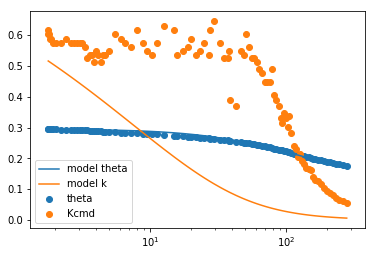

In [5]:
#read in and format the data as needed
kdata = pd.read_csv(r"lmfit_test_kdata.csv")
kdata['h'] = 10**(kdata.pF)
kdata.index = kdata.h
kdata = kdata.drop_duplicates()

data = pd.read_csv(r"lmfit_test.csv")
data.columns = ['pF','theta','weight']
data['h'] = 10**(data.pF)
data = data.drop(columns = ['weight','pF'])
data.index = data.h
data.theta = data.theta/100.
data['Kcmd'] = kdata['K_cmd']
data = data.drop_duplicates()
data = data.dropna()           #dropping Nans here
data = data.sort_index()

#show the data in a scatter plot
plt.scatter(data.h,data.theta)
plt.xscale('log')

plt.scatter(data.h,data.Kcmd)
plt.xscale('log')

#plot the model results with initial guesses against the data
init_guess = swcc_model.eval(params, h = data.h)


plt.plot(data.h, init_guess[0:int(len(init_guess)/2)], label = 'model theta')
plt.plot(data.h, init_guess[int(len(init_guess)/2):], label = 'model k')

plt.legend(loc = 'best')

data.tail()

In [6]:
#fit the objective function to the observation data
result = swcc_model.fit(np.concatenate((data.theta,data.Kcmd)), params = params, weights = None,
                        method = 'cg', h = data.h)

#nan_policy='omit',
#h = np.concatenate((data.h,data.h))

#methods:https://lmfit.github.io/lmfit-py/fitting.html
#omit Nans for cases where the number of retention and k data are different

result

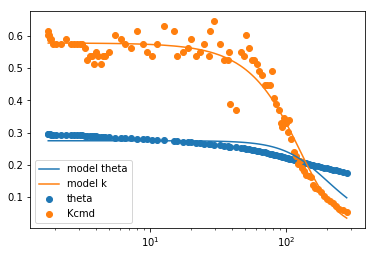

In [7]:
#show the data in a scatter plot
plt.scatter(data.h,data.theta)
plt.xscale('log')

plt.scatter(data.h,data.Kcmd)
plt.xscale('log')

#plot the model results with initial guesses against the data
init_guess = swcc_model.eval(result.params, h = data.h)


plt.plot(data.h, init_guess[0:int(len(init_guess)/2)], label = 'model theta')
plt.plot(data.h, init_guess[int(len(init_guess)/2):], label = 'model k')

plt.legend(loc = 'best')

#still need to figure out why I can't use the dataset with Nans included, and have the fit function "omit" then nans.

ValueError: x and y must have same first dimension, but have shapes (96,) and (192,)

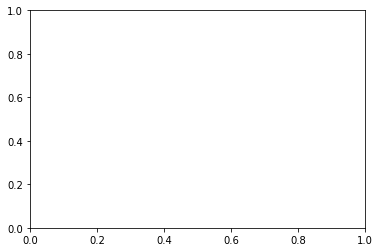

In [8]:
#use the native plotting fuctions
result.plot_fit(fitfmt = '--')
#show model uncertainty on plot, 2 sigma
plt.plot(data.h,data.modeled + result.eval_uncertainty(sigma = 2))
plt.plot(data.h,data.modeled - result.eval_uncertainty(sigma = 2))
plt.xscale('log')

In [ ]:
result.plot_residuals()
plt.xscale('log')